<a href="https://colab.research.google.com/github/purvasingh96/Deep-learning-with-neural-networks/blob/master/Chapter-wise%20code/Code%20-%20PyTorch/2.%20Convolution%20Neural%20Networks/4.%20Transfer%20Learning/Transfer_Learning_predict_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

Use the following command to download zip file and then unzip it -

```
wget <download_link>
!unzip <zip_file_name.zip>

```

In [0]:
! wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip

In [0]:
!unzip flower-photos.zip

# Flower power

Here we'll be using VGGNet to classify images of flowers. We'll start, as usual, by importing our usual resources. And checking if we can train our model on GPU.

In [0]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline



In [0]:
train_on_gpu = torch.cuda.is_available()

# Load and Transform Data
We'll be using PyTorch's ImageFolder class which makes it very easy to load data from a directory. For example, the training images are all stored in a directory path that looks like this:

root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
Where, in this case, the root folder for training is flower_photos/train/ and the classes are the names of flower types.

In [0]:
# define train and test directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

classes = classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Transforming Data
When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects 224-dim square images as input and so, we resize each flower image to fit this mold.

In [0]:
data_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=data_transforms)
test_data = datasets.ImageFolder(test_dir, transform=data_transforms)

# DataLoaders and Data Visualization

In [0]:
batch_size=20
num_workers=0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

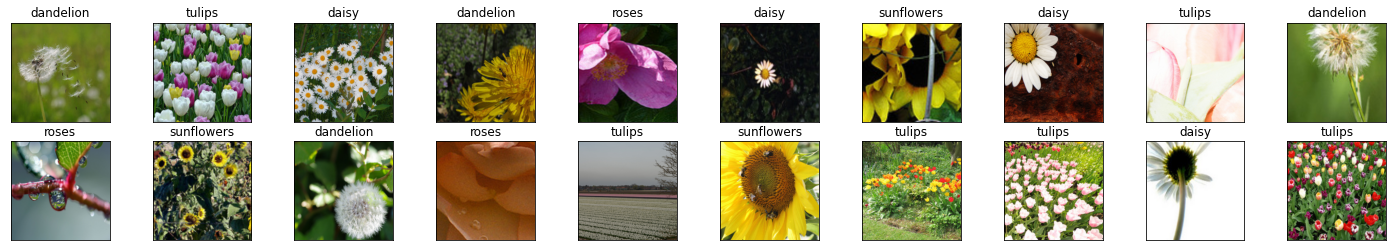

In [15]:

# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

# Define the model
To define a model for training we'll follow these steps:

1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will not change during training.**

In [16]:
# 1. Load in a pre-trained VGG16 model

vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
# 2. Freeze training for all "features" layers
for param in vgg16.features.parameters():
  param.requires_grad = False 

# Final Classifier Layer
Once you have the pre-trained feature extractor, you just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you repace the last layer in the vgg classifier group of layers.

>
>This layer should see as input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task.

You can access any layer in a pretrained network by name and (sometimes) number, i.e. vgg16.classifier[6] is the sixth layer in a group of layers named "classifier". 